In [1]:
#Import Relevant Libraries
import random
import numpy as np
import cvxpy as cp

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector

from qiskit import quantum_info as qi
from toqito.channel_metrics import channel_fidelity

from toqito.state_metrics import fidelity
from toqito.channels import partial_trace as pt
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace

In [2]:
unitary_param_1 = [3.24383098, 3.50187279, 1.26248366, 1.99354817, 4.28031102, 5.99851666, 3.03466457, 4.21065453]

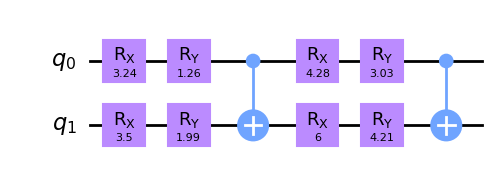

In [3]:
#State \rho_SR
size = 2
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

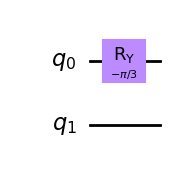

In [4]:
qcTest = QuantumCircuit(2)
qcTest.ry(-np.pi/3, 0)
qcTest.draw('mpl')

In [5]:
I = np.array([[1, 0], [0, 1]])
CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
SWAP = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])

In [6]:
lis = []
lis.append(np.kron(I, I))
temp = np.matmul(SWAP, CNOT)
lis.append(temp)
lis.append(np.matmul(temp, temp))

In [7]:
psi = np.array(DensityMatrix.from_instruction(qcTest.reverse_bits()))
rho = pt(psi, [2], [2, 2]) #rho_S
print(rho)

[[ 0.75     +0.j -0.4330127+0.j]
 [-0.4330127+0.j  0.25     +0.j]]


In [8]:
shape = rho.shape

X = cp.Variable(shape, complex=True)
omega = cp.Variable(np.kron(I, I).shape, complex=True)
G = cp.bmat([[rho, X.H],[X, pt(omega, [2], [2, 2])]])

c = [omega>>0, G>>0, cp.real(cp.trace(omega))==1]

for item in lis:
    c.append(omega@item == item@omega)

obj = cp.Maximize(cp.real(cp.trace(X)))
problem = cp.Problem(obj, constraints = c)
rootFid = problem.solve()
print("Root Fidelity is : " + str(rootFid))

WARN: A->p (column pointers) not strictly increasing, column 20 empty
Root Fidelity is : 0.9155633745992712


In [9]:
print("Fidelity is : " + str(rootFid**2))

Fidelity is : 0.8382562929076054
